[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1aLoeqlaR5_NKvRNaRFMuAJMDVe_Z-Dod?usp=sharing)

In [ ]:
#Instala a biblioteca 'download', que será usada para obter os conjuntos de dados 
!pip install -q download

#Desinstala e instala a biblioteca statsmodels, que usaremos na análise dos dados. 
#Esse procedimento faz-se necessário para garantir que estamos trabalhando com a versão mais recente desta biblioteca.
!pip uninstall -q statsmodels
!pip install -q statsmodels

Proceed (y/n)? y


<h1>Obtenção dos dados</h1>

Os dados usados neste notebook foram obtidos no Federal Reserve Economic Data (FRED), uma instituição ligada ao Federal Reserve de ST. Louis (Banco central dos Estados Unidados da América). Escolhemos esses conjuntos de dados por serem originárias de um segmento de mercado a qual termos experise, o setor elétrico, e estarem disponíveis em uma fonte bastante confiável, o FRED. 

In [ ]:
import download

A China é uma das maiores potências econômicas mundiais e experienciou um crescimento vertiginoso nas últimas décadas, o que pode refletir na produção de eletricidade. Por sua vez, a Alemanha também é uma potência econômica e constitui um dos países mais prósperos da União Europeia, importante bloco econômico global. Detalhes dos dados: China) https://fred.stlouisfed.org/series/CHNPRENEL01MLM; Alemanha) https://fred.stlouisfed.org/series/DEUPREND401IXOBSAM.

In [ ]:
china_filepath = download.download("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=off&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CHNPRENEL01MLM&scale=left&cosd=1999-01-01&coed=2020-11-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-01-25&revision_date=2021-01-25&nd=1999-01-01", "china_electricity_production.csv")
germany_filepath = download.download("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=off&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=DEUPREND401IXOBSAM&scale=left&cosd=1991-01-01&coed=2020-11-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-01-25&revision_date=2021-01-25&nd=1991-01-01", "germany_electricity_production.csv")

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


In [ ]:
#importa as bibliotecas necessárias
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [ ]:
%matplotlib inline
sns.set_style("whitegrid", {"grid.style":"--"})

#Define a espessura das linhas dos gráficos
plt.rc("lines", linewidth=2)
#Vamos ignorar as mensagens de warning
warnings.filterwarnings("ignore")

<h2>Carrega os dados</h2>

In [ ]:
china_electricity = pd.read_csv(china_filepath)
germany_electricity = pd.read_csv(germany_filepath)

In [ ]:
china_electricity.head()

,DATE,CHNPRENEL01MLM
0,1999-01-01,110140.0
1,1999-02-01,81410.0
2,1999-03-01,99010.0
3,1999-04-01,93990.0
4,1999-05-01,96920.0


In [ ]:
germany_electricity.head()

,DATE,DEUPREND401IXOBSAM
0,1991-01-01,92.7
1,1991-02-01,95.2
2,1991-03-01,91.1
3,1991-04-01,92.6
4,1991-05-01,96.2


In [ ]:
#Vamos tornar o nome da segunda coluna mais informativo
china_electricity.rename(columns={"CHNPRENEL01MLM":"electricity_production"}, inplace=True)
germany_electricity.rename(columns={"DEUPREND401IXOBSAM":"electricity_production"}, inplace=True)

In [ ]:
#Vejamos os tipos de dados
print(china_electricity.dtypes)

DATE                       object
electricity_production    float64
dtype: object


In [ ]:
print(germany_electricity.dtypes)

DATE                       object
electricity_production    float64
dtype: object


Precisamos colocar os dados na forma de uma série temporal, em que o índice é constituído de intervalos de tempo, como horas, dias e meses. Neste caso, a coluna 'DATE' torna-se o índice dos dados. Também precisamos garantir que as datas das colunas 'DATE' estão no formato 'datetime'.

In [ ]:
#Converte os valores da coluna 'DATE' para o formato 'datetime'
china_electricity["DATE"] = pd.to_datetime(china_electricity["DATE"])
germany_electricity["DATE"] = pd.to_datetime(germany_electricity["DATE"])

#Define o coluna 'DATE' como índice dos dados
china_electricity = china_electricity.set_index("DATE")
germany_electricity = germany_electricity.set_index("DATE")


print(f"China: {china_electricity.head()}\n\n")
print(f"Alemanha: {germany_electricity.head()}")

China:             electricity_production
DATE                              
1999-01-01                110140.0
1999-02-01                 81410.0
1999-03-01                 99010.0
1999-04-01                 93990.0
1999-05-01                 96920.0


Alemanha:             electricity_production
DATE                              
1991-01-01                    92.7
1991-02-01                    95.2
1991-03-01                    91.1
1991-04-01                    92.6
1991-05-01                    96.2


Um procedimento muito importante consiste em determinar a frequência em que as medições da série temporal analisada foram registradas. 

In [ ]:
#observa a frequência das medições
print(china_electricity.index.freq)

None


In [ ]:
print(germany_electricity.index.freq)

None


Como os dados ainda não contém a frequência da medições, precisamos especificá-la manualmente. Com base nas informações fornecidas pelo FRED, sabemos as medições são mensais. 

In [ ]:
china_electricity.index.freq = "MS" #Monthly Start
germany_electricity.index.freq = "MS" 

In [ ]:
print(f"Frequência para os dados da China: {china_electricity.index.freq}")
print(f"Frequência para os dados da Alemanha: {germany_electricity.index.freq}")

Frequência para os dados da China: <MonthBegin>
Frequência para os dados da Alemanha: <MonthBegin>


Ótimo. A frequência das medições está como definimos.

<h2>Análise exploratória das séries temporais</h2>

Visualiza as séries temporais para a produção de eletricidade na China e Alemanha.

In [ ]:
def plotSeries(dataset, country):
  plt.rc("font", size=12)
  #Cria uma paleta de cores amigável para pessoas daltônicas
  palette = sns.set_palette("colorblind", n_colors=1)

  #Define as dimensões da imagem (largura e altura)
  plt.figure(figsize=(14,5))
  sns.lineplot(data=dataset, palette=palette)
  plt.xlabel("Mês")
  plt.ylabel("Produção de eletricidade (GWh)")
  plt.title(f"Produção de energia elétrica da {country}")
  #O primeiro e o último mês
  plt.xlim(dataset.index.min(), dataset.index.max())
  #Valores superior e inferior do eixo y.
  plt.ylim(dataset.values.min() * 0.95, dataset.values.max() * 1.05)
  #Coloca a legenda na parte superior ao centro da imagem.
  plt.legend().set_visible(False)
  plt.savefig(f"{country}_electricity_production.png", bbox_inches="tight", dpi=600)

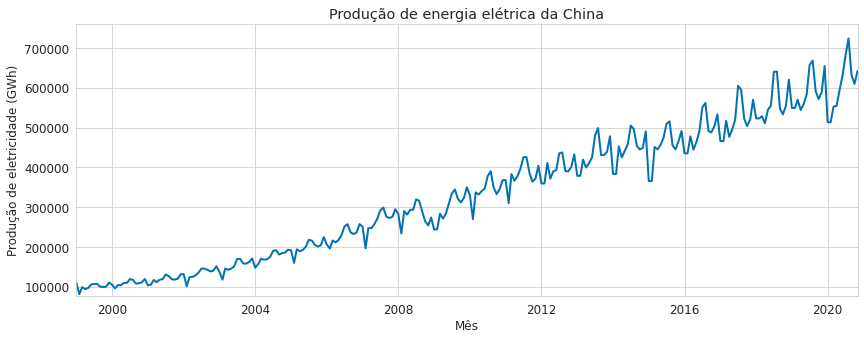

In [ ]:
plotSeries(china_electricity, "China")

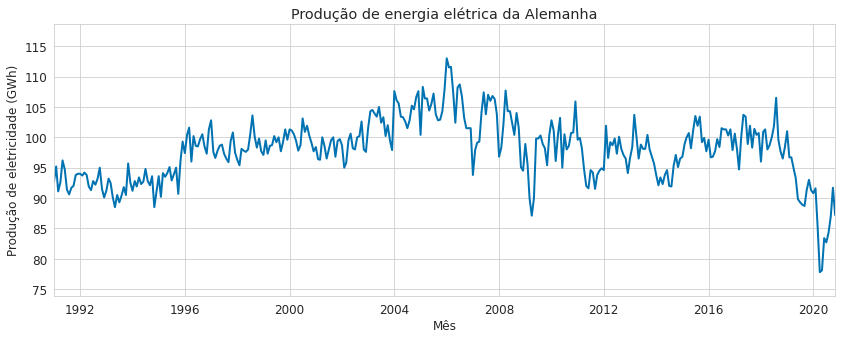

In [ ]:
plotSeries(germany_electricity, "Alemanha")

Gráficos de linhas são muito úteis para observar o comportamento geral dos dados ao longo do tempo. Por exemplo, para a China, podemos observar uma tendência de crescimento na produção de eletricidade ao longo do tempo, desde o início da série de dados. Por outro lado, esta tendência não está clara para a Alemanha. Outro tipo de gráfico muito valioso para a análise de dados, o boxplot, também pode ser utilizado na inspeção de uma série temporal. O boxplot permite observar a evolução de diferentes medidas estatísticas, como mediana e quartis, no tempo, quando estamos lidando com séries temporais

Criaremos uma nova série temporal a partir dos dados atuais, em que teremos um boxplot para cada ano presente no conjunto de dados analisado. Outros intervalos de tempo também podem ser utilizados, desde que possibilite o agrupamento de múltiplos valores. Por exemplo, como estamos analisando dados mensais, a cada ano temos 12 medidas.

In [ ]:
def plotBoxplotSeries(dataset):
  #Número de anos nos dados analisados. Essa variável será necessária para determinar a quantidade cores na paleta, uma para cada ano.
  n_years = len(np.unique(dataset.index.year))
  plt.figure(figsize=(14,6))
  sns.boxplot(x=dataset.index.year, y=dataset["electricity_production"], palette=sns.set_palette("colorblind", n_colors=n_years))
  plt.xlabel("Ano")
  plt.ylabel("Produção de eletricidade (GWh)")
  #Na horizontal, os anos ficam muito próximos, o que dificulta a separação visual entre eles. Por isso, os anos foram rotacionados em 45°.
  plt.xticks(rotation=45, ha="right")

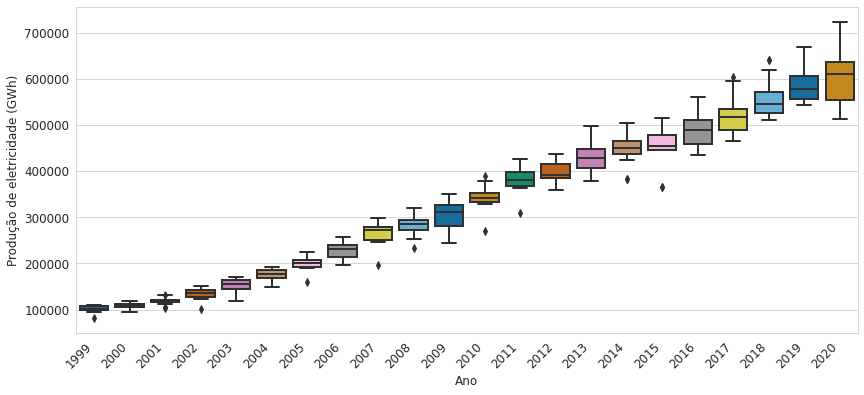

In [ ]:
plotBoxplotSeries(china_electricity)

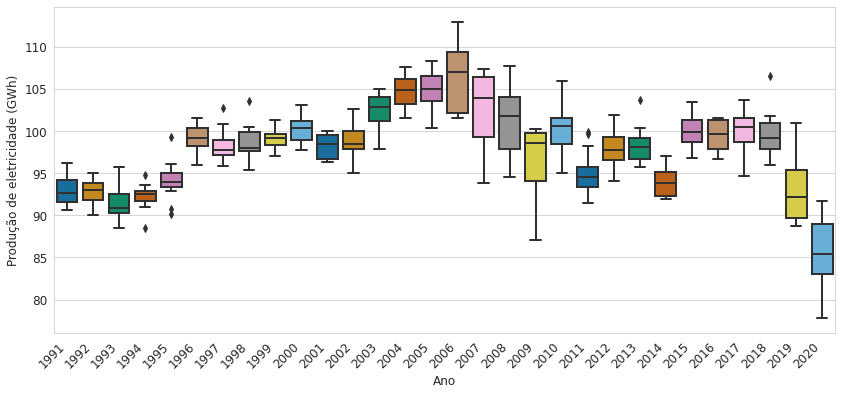

In [ ]:
plotBoxplotSeries(germany_electricity)

<h2>Decomposição de séries temporais</h2>
Uma série temporal é formada pelos seguintes componentes: nível, tendência, sazonalidade e residuais. Nem toda série temporal tem tendência ou sazonalidade. Estes componentes são descritos a seguir:

- Nível: valores medidos em instantes de tempo igualmente intervalados;
- Tendência: padrão de crescimento/declínio nos dados em um período específico.
- Sazonalidade: variações nos dados que ocorrem em intervalos regulares
- Residual: diferença entre valores observados e preditos pelos modelos.

A decomposição de uma série temporal em seus componentes é um passo fundamental no processo de análise da mesma.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
chinaDecomposedSeries = seasonal_decompose(china_electricity)
germanyDecomposedSeries = seasonal_decompose(germany_electricity)

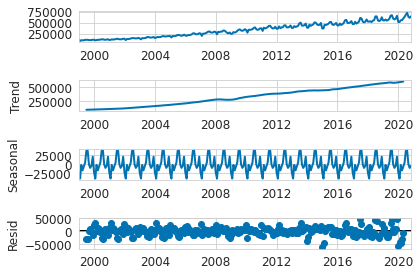

In [ ]:
#Usamos o ponto e vírgula ao final do comando para evitar que o gráfico seja produzido em duplicata.
chinaDecomposedSeries.plot();

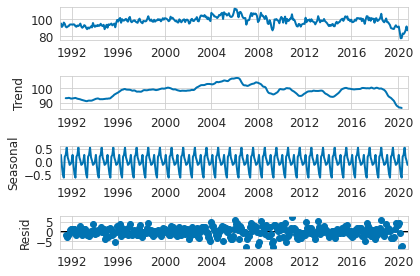

In [ ]:
germanyDecomposedSeries.plot();

Os gráficos acima são interessantes, mas podemos produzir algo visualmente mais agradável.

In [ ]:
def plotDecomposedSeries(series):
  #Cria uma estrutura de dados do tipo dicionário para armazenar os componentes da nossa série temporal
  components = {"Observado":series.observed, "Tendência":series.trend, "Sazonalidade":series.seasonal, "Residual":series.resid}
  #Vamos criar um gráfico para cada componente da nossa série temporal (ax1-ax4)
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16,10), sharex=True) #Os quatros gráficos compartilham o mesmo intervalo de tempo (o eixo x)
  for component_name, component_values, ax in zip(components.keys(), components.values(), [ax1, ax2, ax3, ax4]):
    sns.lineplot(data=component_values, ax=ax)
    ax.set_ylabel(component_name)
    ax.set_xlim(component_values.index.min(), component_values.index.max())
    #Garante que o limite superior do eixo está 60% acima do valor máximo encontrado nos dados, valor definido empiricamente, o que ajuda a evitar que a legenda sobreponha a linha de dados.
    ax.set_ylim(component_values.dropna().values.min(), component_values.dropna().values.max() * 1.60)
    
  plt.xlabel("Mês")

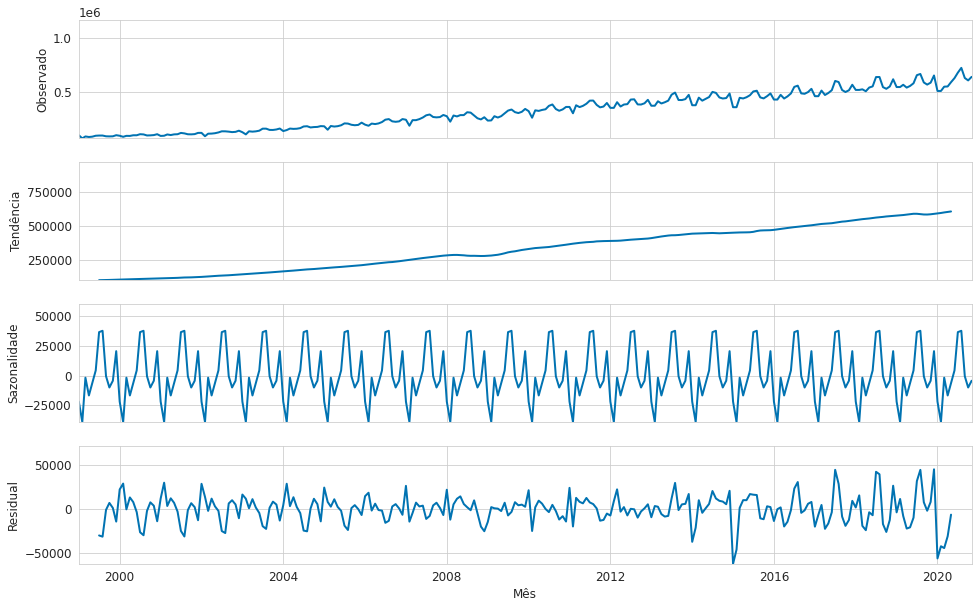

In [ ]:
#China
plotDecomposedSeries(chinaDecomposedSeries)

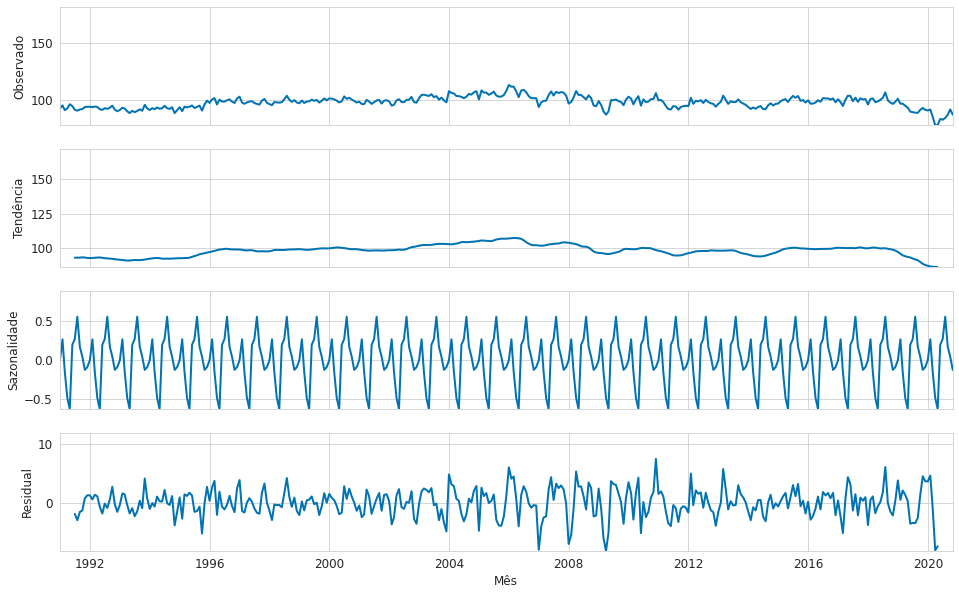

In [ ]:
#Alemanha
plotDecomposedSeries(germanyDecomposedSeries)

Com base nos gráficos acima, podemos chegar a algumas conclusões. Primeiro, claramente existe uma tendência de alta na produção de energia na China. Olhando para o contexto dos dados, essa tendência faz bastante sentido, visto que a China experimenta um crescimento expressivo em sua atividade econômica, o que deve influenciar no consumo de eletricidade. Segundo, também podemos observar uma sazonalidade nos dados. Esses achados são muito importantes para a definição das técnicas e métodos que usaremos para construir os modelos. Por exemplo, precisamos selecionar algoritmos que lidam com esses componentes ou removê-los dos nossos dados.

A fim de aprofundar a análise sobre a tendência e sazonalidade dos dados, aplicamos técnicas que contribuem para destacar estes componentes das séries analisadas. As seguintes técnicas foram utilizadas:



- Tendência:
  * Média móvel simples: calcula a média aritmética de um conjunto de medições provenientes de intervalos fixos (janelas) que deslizam ao longo da série;
  * Média móvel com suavização exponencial: procedimento semelhante ao anterior em que as medições são ponderadas com pesos exponencialmente decrescentes. Nesta técnica, as medidas mais recentes são as mais representativas. 

- Sazonalidade:
  * Média móvel sazonal: para cada instante de tempo, calcula a média dos últimos x momentos no instante correspondente. Por exemplo, para uma série temporal com medições diárias, calcula a média das últimas quatro semanas para cada dia.


<h2>Média móvel simples</h2>

In [ ]:
#Moving Average (MA)
#Número de medidas nas quais será calculada a média aritmética.
windowLength=12 # 12 meses
#As primeiras 'windowLength' medições da série original são substituídas por 'NaN'. Por isso, descartamos ocorrência do 'NaN' com o dropna().
chinaMAElectricityProductionLastTweveMonths = china_electricity.rolling(windowLength).mean().dropna()
germanyMAElectricityProductionLastTweveMonths = germany_electricity.rolling(windowLength).mean().dropna()

In [ ]:
def createMergedDataset(datasets, columns):
  df_merged = pd.concat(datasets, axis=1)
  df_merged.columns = columns 
  return df_merged

def getMinMaxValue(dataset):
  minValuePerColumn = [np.min(dataset[column].values) for column in dataset.columns]
  maxValuePerColumn = [np.max(dataset[column].values) for column in dataset.columns]

  min, max = np.min(minValuePerColumn), np.max(maxValuePerColumn)

  return min, max

def plotMergedSeries(dataset, country, algorithm):
  plt.rc("font", size=12)
  minY, maxY = getMinMaxValue(dataset)
  #Define a expessura das linhas.
  plt.figure(figsize=(14,5))
  sns.lineplot(data=dataset, palette=sns.set_palette("colorblind", n_colors=len(dataset.columns)))
  plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.02), shadow=True, ncol=len(dataset.columns), columnspacing=1)
  plt.xlim(dataset.index.min(), dataset.index.max())
  plt.ylim(minY * 0.95, maxY * 1.05)
  plt.xlabel("Mês")
  plt.ylabel("Produção de eletricidade (GWh)")
  plt.savefig(f"{country}_electricity_production_{algorithm}_predictions.png", bbox_inches="tight", dpi=600)

In [ ]:
df_chinaMA = createMergedDataset(datasets=[china_electricity["electricity_production"].loc["2000-01-01":], chinaMAElectricityProductionLastTweveMonths["electricity_production"].loc["2000-01-01":]], columns=["Original", "Média móvel dos últimos 12 meses"])
df_germanyMA = createMergedDataset(datasets=[germany_electricity["electricity_production"].loc["1992-01-01":], germanyMAElectricityProductionLastTweveMonths["electricity_production"].loc["1992-01-01":]], columns=["Original", "Média móvel dos últimos 12 meses"])

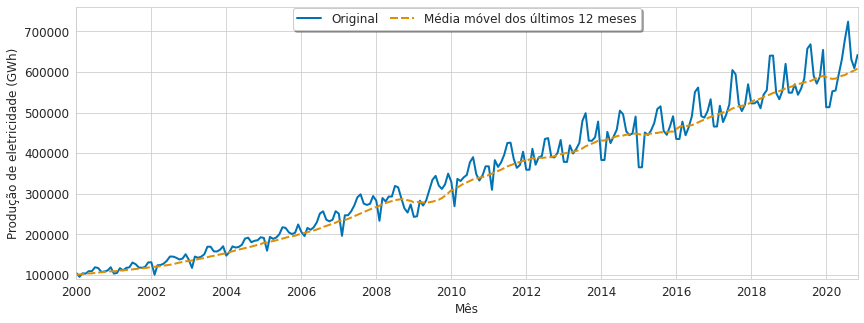

In [ ]:
plotMergedSeries(df_chinaMA, country="China", algorithm="MA")

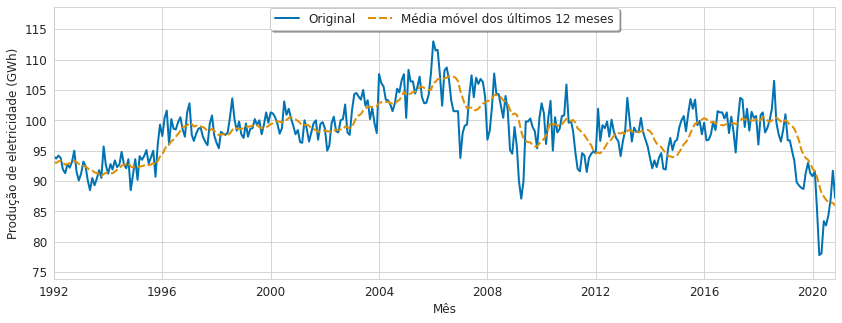

In [ ]:
#Alemanha
plotMergedSeries(df_germanyMA, country="Alemanha", algorithm="MA")

<h2>Média móvel com suavização exponencial</h2>

In [ ]:
#Exponentially Weighted Moving Average (EWMA)
chinaEWMAElectricityProductionLastTweveMonths = china_electricity.ewm(12).mean().dropna()
germanyEWMAElectricityProductionLastTweveMonths = germany_electricity.ewm(12).mean().dropna()

In [ ]:
#Cria dataframes com os dados originais e suas contrapartes construídas com a suavização exponencial
df_chinaEWMA = createMergedDataset(datasets=[china_electricity["electricity_production"].loc["2000-01-01":], chinaEWMAElectricityProductionLastTweveMonths["electricity_production"].loc["2000-01-01":], chinaMAElectricityProductionLastTweveMonths.loc["2000-01-01":]], columns=["Original", "Média móvel dos últimos 12 meses", "Suavização exponencial dos últimos 12 meses"])
df_germanyEWMA = createMergedDataset(datasets=[germany_electricity["electricity_production"].loc["1993-01-01":], germanyEWMAElectricityProductionLastTweveMonths["electricity_production"].loc["1993-01-01":], germanyMAElectricityProductionLastTweveMonths.loc["1993-01-01":]], columns=["Original", "Média móvel dos últimos 12 meses", "Suavização exponencial dos últimos 12 meses"])

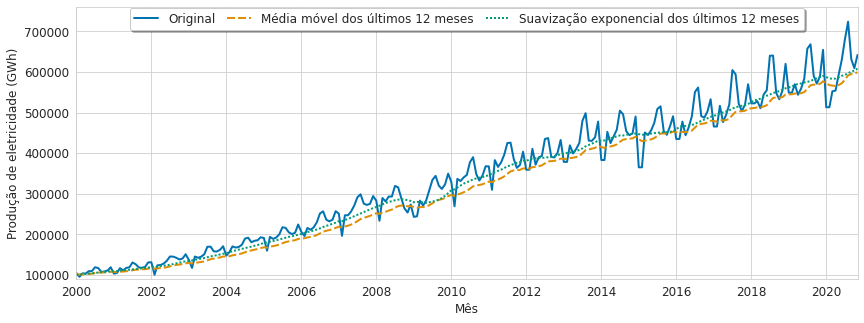

In [ ]:
plotMergedSeries(df_chinaEWMA, country="China", algorithm="EWMA")

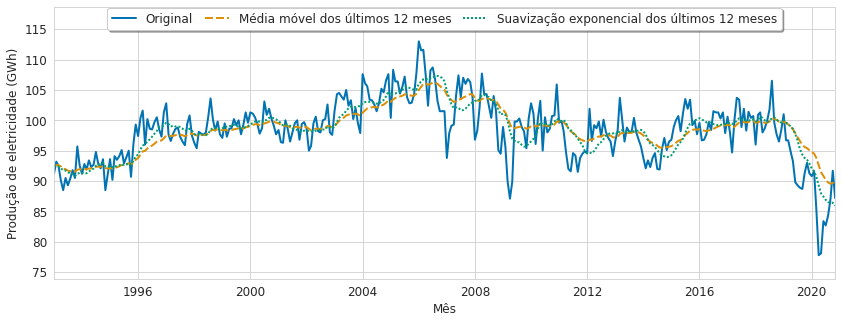

In [ ]:
plotMergedSeries(df_germanyEWMA, country="Alemanha", algorithm="EWMA")

<h3>Estacionariedade</h3>
Estacionariedade é uma propriedade estatística caracterizada pela presença de média e desvio padrão constantes ao longo do tempo. Essa propriedade é muito importante em séries temporais e muitas técnicas e algoritmos dependem da sua presença na série investigada. 

In [ ]:
#Implementação do teste "Dickey-Fuller aumentado"
from statsmodels.tsa.stattools import adfuller

In [ ]:
#Define uma função que determina se a série passada como argumento é estacionária.
def stationarityTest(series):
    adtestResult = adfuller(series.values)
    pValue = adtestResult[1]
    alpha = 0.05
    if pValue >= alpha:
        print(adtestResult)
        return "Essa série temporal não é estacionária."
    else:
        print(adtestResult)
        return "Essa série temporal é estacionária."

In [ ]:
stationarityTest(china_electricity["electricity_production"])

(1.2500170705199443, 0.9963138745019477, 13, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, 5431.547253459652)


'Essa série temporal não é estacionária.'

In [ ]:
stationarityTest(germany_electricity["electricity_production"])

(-3.5031037020385294, 0.007907741278894417, 2, 356, {'1%': -3.448853029339765, '5%': -2.869693115704379, '10%': -2.571113512498422}, 1642.1583139602958)


'Essa série temporal é estacionária.'

<h3>Diferenciação</h3>

Como pode ser observado acima, existem séries temporais não estacionárias. Também existem formas de tornar uma série estacionária. A técnica mais popular para tornar uma série estacionária é chamada de diferenciação, que é capaz de remover a tendência nos dados. Uma variação desta técnica, conhecida como diferenciação sazonal (ou ajuste da sazonalidade), têm um propósito semelhante, mas como o seu nome sugere, é capaz de remover a sazonalidade. 

A diferenciação consiste em subtrair da medição do instante atual o valor observado em x instantes passados. Por exemplo, subtrair de cada valor o seu antecessor na série de dados. Esse procedimento pode ser repetido várias vezes para a mesma série. 

In [ ]:
from statsmodels.tsa.statespace.tools import diff

In [ ]:
chinaElectricityDiff = diff(china_electricity)

In [ ]:
stationarityTest(chinaElectricityDiff["electricity_production"])

(-5.747620374329013, 6.069697863903295e-07, 12, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, 5409.448251613347)


'Essa série temporal é estacionária.'

In [ ]:
#Vejamos como estão os dados originais comparados aos "diferenciados"
def plotDiffSeries(dataset, datasetDiff):
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True)
  sns.lineplot(data=dataset["electricity_production"], label="Medições originais", ax=ax1, palette=sns.set_palette("colorblind", n_colors=1))
  sns.lineplot(data=datasetDiff["electricity_production"], label="Medições diferenciadas", ax=ax2, palette=sns.set_palette("colorblind", n_colors=1))
  for ax, df, ylabel in zip([ax1, ax2], [china_electricity, chinaElectricityDiff], ["Produção de eletricidade (GWh)", "Produção de eletricidade ajustada"]):
      ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.02), shadow=True)
      #Define os limites mínimo e máximo do eixo y dos gráficos. 
      ax.set_ylim(df.values.min() * 1.1, df.values.max() * 1.4)
      #Define os limites mínimo e máximo do eixo x.
      ax.set_xlim(df.index.min(), df.index.max())
      ax.set_ylabel(ylabel)
  plt.xlabel("Mês")


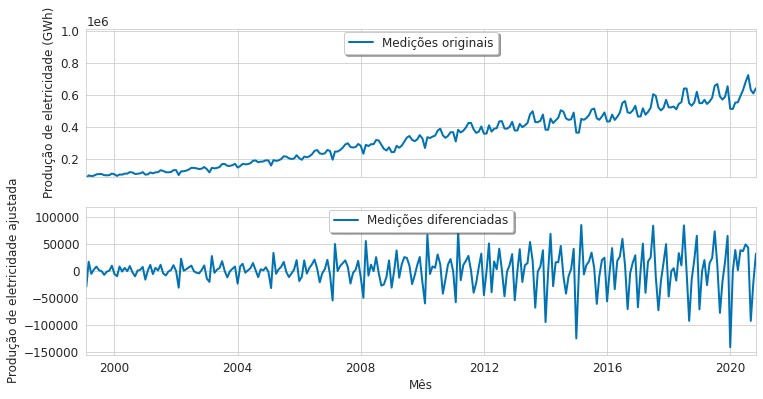

In [ ]:
plotDiffSeries(dataset=china_electricity, datasetDiff=chinaElectricityDiff)

<h3>Diferenciação sazonal (também conhecida como ajuste da sazonalidade)</h3>

In [ ]:
def difference(dataset, interval=1, order=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    if order > 1:
        return difference(pd.Series(diff), interval, order-1)
    else:
        return pd.Series(diff)

In [ ]:
chinaSeasonalDiff = difference(china_electricity["electricity_production"], interval=12)

Text(0.5, 0, 'Mês')

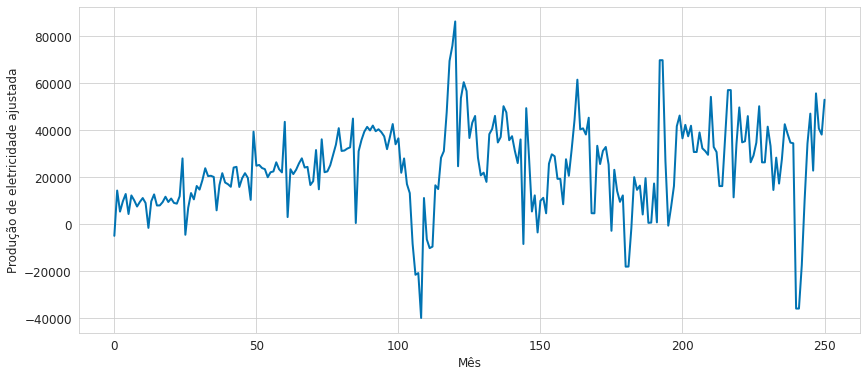

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(data=chinaSeasonalDiff, palette=sns.set_palette("colorblind", n_colors=1))
plt.ylabel("Produção de eletricidade ajustada")
plt.xlabel("Mês")

In [ ]:
stationarityTest(chinaSeasonalDiff)

(-4.399972548611535, 0.00029686582900630197, 12, 238, {'1%': -3.458128284586202, '5%': -2.873761835239286, '10%': -2.5732834559706235}, 5161.999221269204)


'Essa série temporal é estacionária.'

<h3>Média móvel sazonal</h3>

In [ ]:
from dateutil.relativedelta import *

In [ ]:
def seasonalMovingAverage(dataset, start_date, n_years):
    #Lista das médias calculadas
    seasonal_mean = []
    for index, value in dataset.loc[start_date:].items():
        #Seleciona os valores dos últimos "n_years" anos observados no mês atual
        temp = [dataset.loc[pd.to_datetime(index) - relativedelta(years=year)] for year in range(1,n_years+1)]
        #Calcula a média dos valores selecionados e armazena em uma lista
        seasonal_mean.append(np.mean(temp))
        
    
    #converte a lista de médias para o formato de Series do Pandas
    mean_series = pd.Series(index=dataset.loc[start_date:].index.values, data=seasonal_mean)
    
    return mean_series

In [ ]:
chinaSeasonalMovingAverage = seasonalMovingAverage(dataset=china_electricity["electricity_production"], start_date="2004-01-01", n_years=5)
germanySeasonalMovingAverage = seasonalMovingAverage(dataset=germany_electricity["electricity_production"], start_date="1997-01-01", n_years=5)

In [ ]:
df_chinaSMA = createMergedDataset(datasets=[china_electricity.loc["2004-01-01":], chinaSeasonalMovingAverage.loc["2004-01-01":]], columns=["Dados originais da China","Dados da China com média sazonal"])
df_germanySMA = createMergedDataset(datasets=[germany_electricity.loc["1997-01-01":], germanySeasonalMovingAverage.loc["1997-01-01":]], columns=["Dados originais da Alemanha","Dados da Alemanha com média sazonal"])

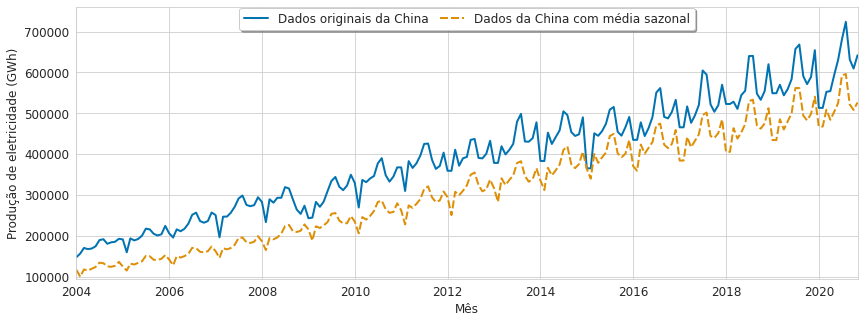

In [ ]:
plotMergedSeries(df_chinaSMA, country="China", algorithm="SeasonalMovingAverage")

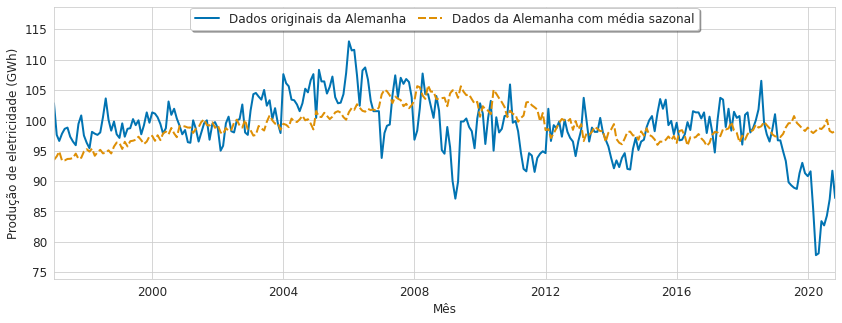

In [ ]:
plotMergedSeries(df_germanySMA, country="Alemanha", algorithm="SeasonalMovingAverage")

<h1>Construção dos modelos</h1>

Descrição dos algoritmos selecionados:
- SARIMA: extensão do algoritmo Autoregressive Integrated Moving Average (ARIMA), um dos métodos para predição de séries temporais mais populares, capaz de lidar com dados sazonais. Como os dados analisados apresentam sazonalidade, selecionamos o SARIMA ao invés do tradicional ARIMA;
- Holt-Winters: método preditivo que incorpora a técnica de suavização exponencial para nível, tendência e sazonalidade de uma de uma série temporal;
- Facebook Prophet: procedimento preditivo baseado em modelos aditivos capaz de lidar com dados sazonais.

In [ ]:
#Dicionário para armazenar os modelos
models = {}

#Dicionário para armazenar as predições dos modelos
predictions = {}

#Armazena os resultados das métricas de avaliação
chinaResults = {"MAE":[], "RMSE":[], "U1":[], "U2":[]}
germanyResults = {"MAE":[], "RMSE":[], "U1":[], "U2":[]}

<h3>Divisão dos dados em conjuntos de treino e teste</h3>

In [ ]:
from datetime import timedelta

In [ ]:
def splitTrainTest(dataset, threshold_date):
    train = dataset[:threshold_date]
    #Desloca um mês a frente para garantir que não há sobreposição de datas
    test = dataset[pd.to_datetime(threshold_date)+timedelta(days=30):]
    
    return train, test

In [ ]:
trainChina, testChina = splitTrainTest(china_electricity, "2018-12-01")
trainGermany, testGermany = splitTrainTest(germany_electricity, "2018-12-01")

In [ ]:
print(f"{trainChina.tail()}\n")
print(testChina.head())

            electricity_production
DATE                              
2018-08-01                640500.0
2018-09-01                548300.0
2018-10-01                533000.0
2018-11-01                554300.0
2018-12-01                620000.0

            electricity_production
DATE                              
2019-01-01                549100.0
2019-02-01                549100.0
2019-03-01                569800.0
2019-04-01                544000.0
2019-05-01                558900.0


In [ ]:
print(f"{trainGermany.tail()}\n")
print(testGermany.head())

            electricity_production
DATE                              
2018-08-01                   106.5
2018-09-01                    99.6
2018-10-01                    97.7
2018-11-01                    96.5
2018-12-01                    98.4

            electricity_production
DATE                              
2019-01-01                   101.0
2019-02-01                    96.7
2019-03-01                    96.7
2019-04-01                    94.9
2019-05-01                    93.3


<h3>Seasonal AutoRegressive Integrated Moving Average (SARIMA)</h2>

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
#Instala a biblioteca pmdarima
!pip install -q pmdarima

In [ ]:
from pmdarima import auto_arima

Instalamos a biblioteca pmdarima para que possamos utilizar o algoritmo "auto ARIMA". Esse algoritmo é muito utilizado para seleção dos valores dos parâmetros do modelo construído com base no SARIMA.

<h3>China</h3>

In [ ]:
#m: período para diferenciação sazonal. M refere-se ao número de períodos em cada temporada. Por exemplo, m é 12 para dados mensais.
chinaAutoArimaModel = auto_arima(china_electricity, seasonal=True, m=12)
print(chinaAutoArimaModel.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  263
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -2742.101
Date:                                 Tue, 02 Mar 2021   AIC                           5496.202
Time:                                         19:09:16   BIC                           5517.331
Sample:                                              0   HQIC                          5504.706
                                                 - 263                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4613      0.139      3.326      0.001       0.189       0

In [ ]:
#Cria o modelo. Usamos os valores dos parâmetros selecionados pelo "auto ARIMA" (segunda linha dos relatórios acima)
china_arima_model = SARIMAX(trainChina, order=(1, 1, 1), seasonal_order=(1, 1, [1, 2], 12))
#Ajusta o modelo aos dados
china_fitted_model = china_arima_model.fit()
#Apresenta uma descrição resumida do modelo criado
print(china_fitted_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                  electricity_production   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -2477.048
Date:                                 Tue, 02 Mar 2021   AIC                           4966.097
Time:                                         19:09:18   BIC                           4986.647
Sample:                                     01-01-1999   HQIC                          4974.389
                                          - 12-01-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3562      0.156      2.289      0.022       0.051       0

<h3>Alemanha</h3>

In [ ]:
germanyAutoArimaModel = auto_arima(germany_electricity, seasonal=True, m=12)
print(germanyAutoArimaModel.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  359
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -843.778
Date:                            Tue, 02 Mar 2021   AIC                           1697.556
Time:                                    19:10:35   BIC                           1716.959
Sample:                                         0   HQIC                          1705.273
                                            - 359                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5259      0.078      6.755      0.000       0.373       0.679
ma.L1         -0.8208      0.050   

In [ ]:
germany_arima_model = SARIMAX(trainGermany, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
germany_fitted_model = germany_arima_model.fit()
print(germany_fitted_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:             electricity_production   No. Observations:                  336
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -778.827
Date:                            Tue, 02 Mar 2021   AIC                           1567.653
Time:                                    19:10:36   BIC                           1586.724
Sample:                                01-01-1991   HQIC                          1575.256
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5099      0.069      7.436      0.000       0.375       0.644
ma.L1         -0.8609      0.038   

In [ ]:
models["SARIMA_china"] = china_fitted_model
models["SARIMA_germany"] = germany_fitted_model
print(models)

{'SARIMA_china': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f6410bb5950>, 'SARIMA_germany': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f63f18baf10>}


In [ ]:
startChina = len(trainChina)
endChina = startChina + 12 - 1 

startGermany = len(trainGermany)
endGermany = startGermany + 12 - 1 

In [ ]:
predictions["SARIMA_china"] = models["SARIMA_china"].predict(startChina, endChina, typ="levels").rename("SARIMA predictions")
predictions["SARIMA_germany"] = models["SARIMA_germany"].predict(startGermany, endGermany, typ="levels").rename("SARIMA predictions")

<h3>Holt-Winters</h3>

In [ ]:
china_model = ExponentialSmoothing(trainChina["electricity_production"], trend="add", seasonal="add", seasonal_periods=12)
china_fitted_model = china_model.fit()
germany_model = ExponentialSmoothing(trainGermany["electricity_production"], trend="add", seasonal="add", seasonal_periods=12)
germany_fitted_model = germany_model.fit()

In [ ]:
models["Holt-Winters_china"] = china_fitted_model
models["Holt-Winters_germany"] = germany_fitted_model

predictions["Holt-Winters_china"] = models["Holt-Winters_china"].predict(startChina, endChina)
predictions["Holt-Winters_germany"] = models["Holt-Winters_germany"].predict(startGermany, endGermany)

<h3>Facebook Prophet</h3>

In [ ]:
import fbprophet

In [ ]:
china_dataframe = pd.DataFrame()
china_dataframe["ds"] = trainChina.index
china_dataframe["y"] = trainChina.values

germany_dataframe = pd.DataFrame()
germany_dataframe["ds"] = trainGermany.index
germany_dataframe["y"] = trainGermany.values

print(f"China:\n{china_dataframe.head()}\n\n")
print(f"Alemanha:\n{germany_dataframe.head()}")

China:
          ds         y
0 1999-01-01  110140.0
1 1999-02-01   81410.0
2 1999-03-01   99010.0
3 1999-04-01   93990.0
4 1999-05-01   96920.0


Alemanha:
          ds     y
0 1991-01-01  92.7
1 1991-02-01  95.2
2 1991-03-01  91.1
3 1991-04-01  92.6
4 1991-05-01  96.2


In [ ]:
china_model = fbprophet.Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False, seasonality_mode = 'additive')
germany_model = fbprophet.Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False, seasonality_mode = 'additive')

In [ ]:
china_fitted_model = china_model.fit(china_dataframe)
germany_fitted_model = germany_model.fit(germany_dataframe)

In [ ]:
china_future = china_model.make_future_dataframe(periods=12, freq="MS")
germany_future = germany_model.make_future_dataframe(periods=12, freq="MS")

In [ ]:
models["prophet_china"] = china_fitted_model
models["prophet_germany"] = germany_fitted_model

predictions["prophet_china"] = models["prophet_china"].predict(china_future).set_index("ds").loc["2019-01-01":"2019-12-01"]["yhat"]
predictions["prophet_germany"] = models["prophet_germany"].predict(germany_future).set_index("ds").loc["2019-01-01":"2019-12-01"]["yhat"]

<h2>Avaliação quantitativa dos modelos</h2>

<h3>Implementação da métrica U de Theil</h3>

In [ ]:
def computeTheilU1(y_true, y_pred):
    N = len(y_true)

    powerNumerator = np.power(y_true - y_pred, 2)
    summationNumerator = np.sum(powerNumerator)
    meanNumerator = (1/N) * summationNumerator
    numerator = np.sqrt(meanNumerator)

    summationTest = np.sum(np.power(y_true, 2))
    meanTest = (1/N) * summationTest
    sqrtTest = np.sqrt(meanTest)
    
    summationPredicted = np.sum(np.power(y_pred, 2))
    meanPredicted = (1/N) * summationPredicted
    sqrtPredicted = np.sqrt(meanPredicted)
    
    denominator = sqrtTest + sqrtPredicted
    
    theilU1 = numerator/denominator

    return theilU1

In [ ]:
def division(measure, previousI):
  return measure / previousI

def power(measure):
  return np.power(measure, 2)

def summation(measure):
  return np.sum(measure)

def mean(N, measure):
  return (1/N) * measure

def sqrt(measure):
  return np.sqrt(measure)

def computeTheilU2(y_true, y_pred):
    N = len(y_true)
    
    subtractionNumerator = y_pred[1:] - y_true[1:]
    divisionNumerator = division(subtractionNumerator, y_true[:-1])
    powerNumerator = power(divisionNumerator)
    summationNumerator = summation(powerNumerator)
    meanNumerator = mean(N, summationNumerator)
    numerator = sqrt(meanNumerator)
    
    subtractionDenominator = y_true[1:] - y_true[:-1]
    powerDenominator = power(division(subtractionDenominator, y_true[:-1]))
    denominator = sqrt(mean(N, summation(powerDenominator)))
        
    theilU2 = numerator / denominator
    
    return theilU2

In [ ]:
def evaluateModel(test_data, predicted_data, results, model_name):
    mae = mean_absolute_error(test_data, predicted_data)
    rmse = np.sqrt(mean_squared_error(test_data, predicted_data))
    u1 = computeTheilU1(test_data.values.reshape(-1,1), predicted_data.values.reshape(-1,1))
    u2 = computeTheilU2(test_data.values.reshape(-1,1), predicted_data.values.reshape(-1,1))
    results[f"MAE"].append((model_name, mae))
    results[f"RMSE"].append((model_name, rmse))
    results[f"U1"].append((model_name, u1))
    results[f"U2"].append((model_name, u2))

    print("| Theil U1\t| Theil U2\t| MAE\t\t| RMSE\t\t|")
    print(f"| {u1:.2f}\t\t| {u2:.2f}\t\t| {mae:.2f}\t| {rmse:.2f}\t|")

    return results

<h3>SARIMA</h3>

In [ ]:
df_sarima_china = createMergedDataset(datasets=[testChina.loc["2019-01-01":"2019-12-01"], predictions["SARIMA_china"].loc["2019-01-01":"2019-12-01"]], columns=["Medições originais para a China", "Predições do modelo SARIMA"])
df_sarima_germany = createMergedDataset(datasets=[testGermany.loc["2019-01-01":"2019-12-01"], predictions["SARIMA_germany"].loc["2019-01-01":"2019-12-01"]], columns=["Medições originais para a Alemanha", "Predições do modelo SARIMA"])

In [ ]:
df_sarima_china

,Medições originais para a China,Predições do modelo SARIMA
DATE,,
2019-01-01,549100.0,559485.508295
2019-02-01,549100.0,556816.311148
2019-03-01,569800.0,577010.254247
2019-04-01,544000.0,552826.377306
2019-05-01,558900.0,581022.675104
2019-06-01,583400.0,596174.056308
2019-07-01,657300.0,673617.591367
2019-08-01,668200.0,674325.343699
2019-09-01,590800.0,591777.527439


In [ ]:
df_sarima_germany

,Medições originais para a Alemanha,Predições do modelo SARIMA
DATE,,
2019-01-01,101.0,99.506304
2019-02-01,96.7,99.175939
2019-03-01,96.7,99.706356
2019-04-01,94.9,99.637473
2019-05-01,93.3,99.125406
2019-06-01,89.8,98.573844
2019-07-01,89.3,98.498558
2019-08-01,88.9,97.289818
2019-09-01,88.7,98.845883


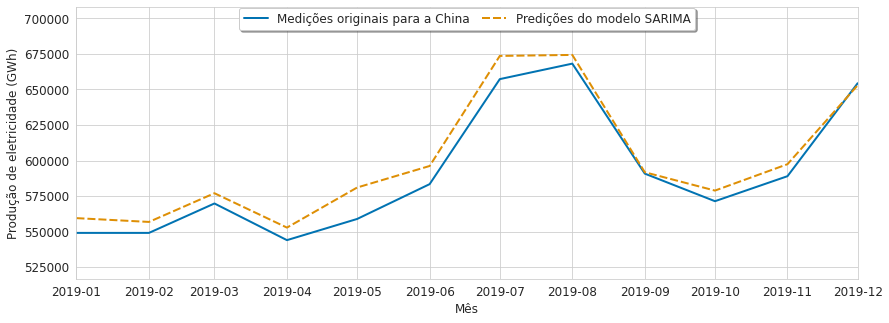

In [ ]:
plotMergedSeries(df_sarima_china, "China", "SARIMA")

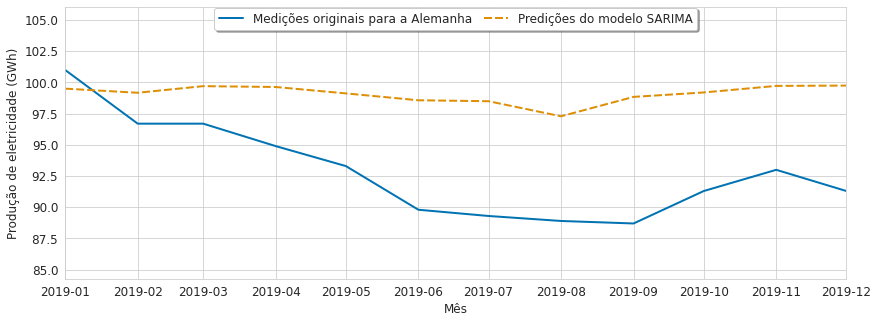

In [ ]:
plotMergedSeries(df_sarima_germany, "Alemanha", "SARIMA")

In [ ]:
chinaResults = evaluateModel(test_data=testChina.loc["2019-01-01":"2019-12-01"], predicted_data=predictions["SARIMA_china"].loc["2019-01-01":"2019-12-01"], results=chinaResults, model_name="SARIMA")

| Theil U1	| Theil U2	| MAE		| RMSE		|
| 0.01		| 0.28		| 9152.88	| 10738.51	|


In [ ]:
germanyResults = evaluateModel(test_data=testGermany.loc["2019-01-01":"2019-12-01"], predicted_data=predictions["SARIMA_germany"].loc["2019-01-01":"2019-12-01"], results=germanyResults, model_name="SARIMA")

| Theil U1	| Theil U2	| MAE		| RMSE		|
| 0.04		| 3.60		| 6.43	| 7.00	|


<h3>Holt-Winters</h3>

In [ ]:
df_holtWintersChina = createMergedDataset(datasets=[testChina.loc["2019-01-01":"2019-12-01"], predictions["Holt-Winters_china"].loc["2019-01-01":"2019-12-01"]], columns=["Medições originais para a China", "Predições do modelo Holt-Winters"])
df_holtWintersGermany = createMergedDataset(datasets=[testGermany.loc["2019-01-01":"2019-12-01"], predictions["Holt-Winters_germany"].loc["2019-01-01":"2019-12-01"]], columns=["Medições originais para a Alemanha", "Predições do modelo Holt-Winters"])

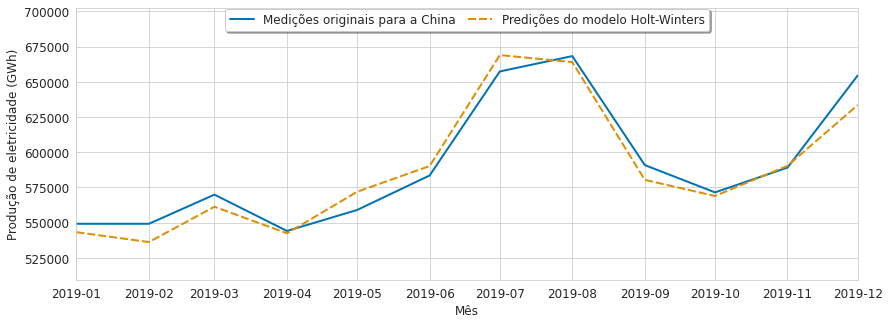

In [ ]:
plotMergedSeries(df_holtWintersChina, "China", "Holt-Winters")

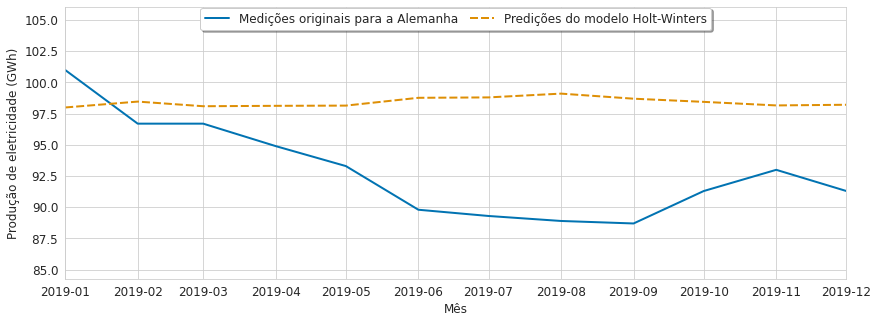

In [ ]:
plotMergedSeries(df_holtWintersGermany, "Alemanha", "Holt-Winters")

In [ ]:
chinaResults = evaluateModel(test_data=testChina.loc["2019-01-01":"2019-12-01"], predicted_data=predictions["Holt-Winters_china"].loc["2019-01-01":"2019-12-01"], results=chinaResults, model_name="Holt-Winters")

| Theil U1	| Theil U2	| MAE		| RMSE		|
| 0.01		| 0.26		| 8338.02	| 10023.74	|


In [ ]:
germanyResults = evaluateModel(test_data=testGermany.loc["2019-01-01":"2019-12-01"], predicted_data=predictions["Holt-Winters_germany"].loc["2019-01-01":"2019-12-01"], results=germanyResults, model_name="Holt-Winters")

| Theil U1	| Theil U2	| MAE		| RMSE		|
| 0.04		| 3.47		| 6.01	| 6.76	|


<h3>Prophet</h3>

In [ ]:
df_prophet_china = createMergedDataset(datasets=[testChina.loc["2019-01-01":"2019-12-01"], predictions["prophet_china"].loc["2019-01-01":"2019-12-01"]], columns=["Medições originais para a China", "Predições do modelo Prophet"])
df_prophet_germany = createMergedDataset(datasets=[testGermany.loc["2019-01-01":"2019-12-01"], predictions["prophet_germany"].loc["2019-01-01":"2019-12-01"]], columns=["Medições originais para a Alemanha", "Predições do modelo Prophet"])

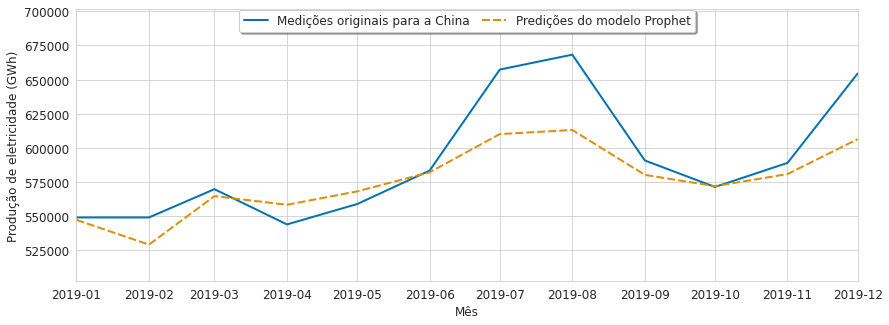

In [ ]:
plotMergedSeries(df_prophet_china, "China", "Prophet")

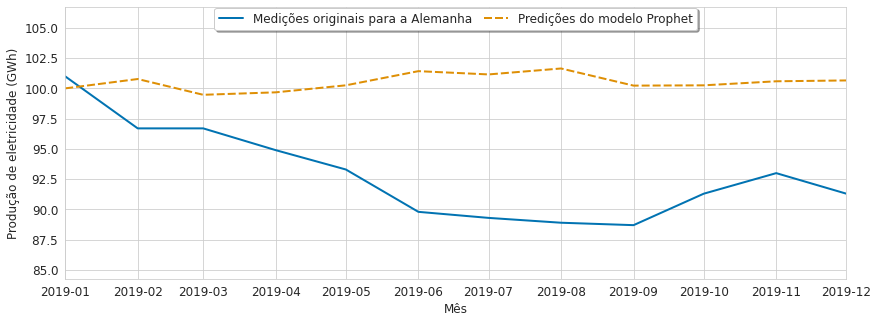

In [ ]:
plotMergedSeries(df_prophet_germany, "Alemanha", "prophet")

In [ ]:
chinaResults = evaluateModel(test_data=testChina.loc["2019-01-01":"2019-12-01"], predicted_data=predictions["prophet_china"].loc["2019-01-01":"2019-12-01"] , results=chinaResults, model_name="Prophet")

| Theil U1	| Theil U2	| MAE		| RMSE		|
| 0.02		| 0.68		| 18439.92	| 26564.42	|


In [ ]:
germanyResults = evaluateModel(test_data=testGermany.loc["2019-01-01":"2019-12-01"], predicted_data=predictions["prophet_germany"].loc["2019-01-01":"2019-12-01"] , results=germanyResults, model_name="Prophet")

| Theil U1	| Theil U2	| MAE		| RMSE		|
| 0.04		| 4.45		| 7.77	| 8.63	|


<h2>Comparação entre modelos</h2>

In [ ]:
#reune as predições dos três modelos para a produção de eletricidade da China
df_models_china = createMergedDataset(datasets=[testChina.loc["2019-01-01":"2019-12-01"], predictions["SARIMA_china"].loc["2019-01-01":"2019-12-01"], predictions["Holt-Winters_china"].loc["2019-01-01":"2019-12-01"], predictions["prophet_china"].loc["2019-01-01":"2019-12-01"]], columns=["Medições originais para a China", "Predições do modelo SARIMA", "Predições do modelo Holt-Winters", "Predições do modelo Prophet"])
df_models_germany = createMergedDataset(datasets=[testGermany.loc["2019-01-01":"2019-12-01"], predictions["SARIMA_germany"].loc["2019-01-01":"2019-12-01"], predictions["Holt-Winters_germany"].loc["2019-01-01":"2019-12-01"], predictions["prophet_germany"].loc["2019-01-01":"2019-12-01"]], columns=["Medições originais para a Alemanha", "Predições do modelo SARIMA", "Predições do modelo Holt-Winters", "Predições do modelo Prophet"])

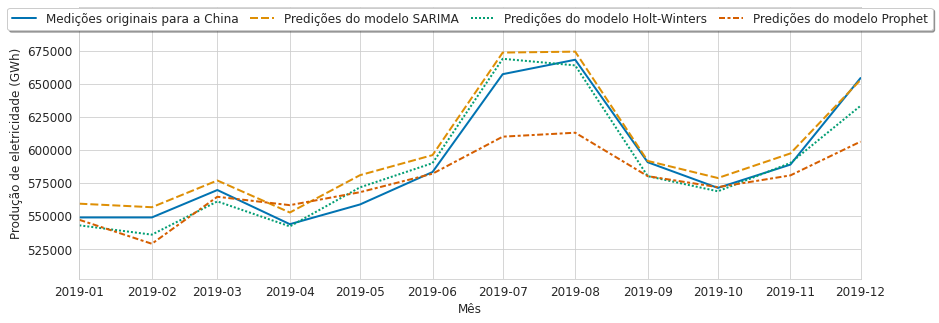

In [ ]:
plotMergedSeries(df_models_china, "China", "todosOsAlgoritmos")

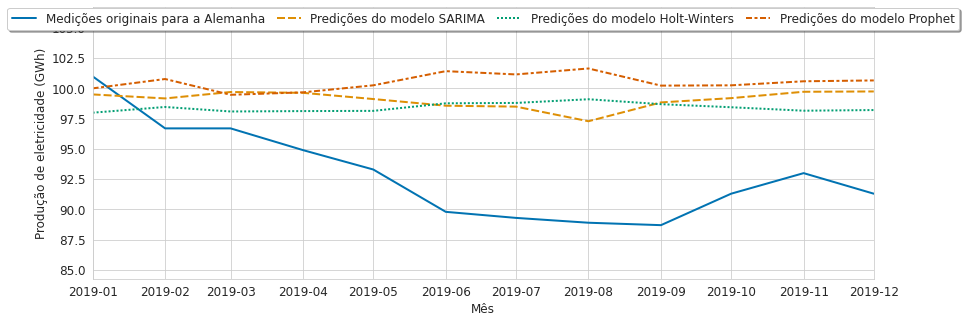

In [ ]:
plotMergedSeries(df_models_germany, "Alemanha", "todosOsAlgoritmos")

<h3>Comparação do desempenho com base nas métricas de avaliação</h3>

In [ ]:
df_mae_china = pd.DataFrame(chinaResults["MAE"], columns=["Modelo", "Desempenho"])
df_rmse_china = pd.DataFrame(chinaResults["RMSE"], columns=["Modelo", "Desempenho"])
df_mae_germany = pd.DataFrame(germanyResults["MAE"], columns=["Modelo", "Desempenho"])
df_rmse_germany = pd.DataFrame(germanyResults["RMSE"], columns=["Modelo", "Desempenho"])

#Como os valores de U1 foram muito semelhantes entre os diferentes modelos, vamos analisar somente a U2.
df_u2_china = pd.DataFrame(chinaResults["U2"], columns=["Modelo", "Desempenho"])
df_u2_germany = pd.DataFrame(germanyResults["U2"], columns=["Modelo", "Desempenho"])

In [ ]:
def plotPerformanceComparation(dataset, metric_name):
  plt.figure(figsize=(10,6))
  sns.barplot(x=dataset["Modelo"], y=dataset["Desempenho"], palette=sns.set_palette("colorblind", n_colors=3))
  if metric_name in ["MAE", "RMSE"]:
    plt.ylabel(f"{metric_name} (GWh)")
  else:
    plt.ylabel(f"{metric_name}")

<h3>China</h3>

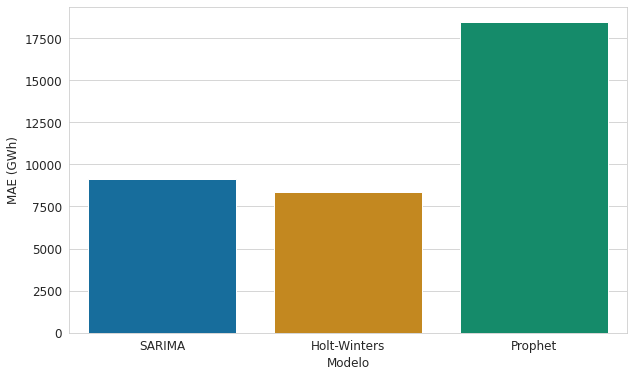

In [ ]:
plotPerformanceComparation(df_mae_china, "MAE")

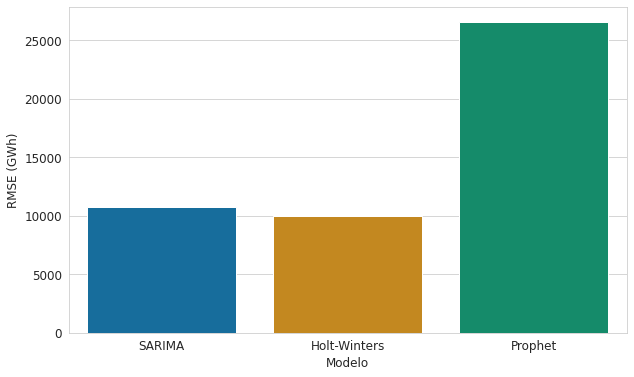

In [ ]:
plotPerformanceComparation(df_rmse_china, "RMSE")

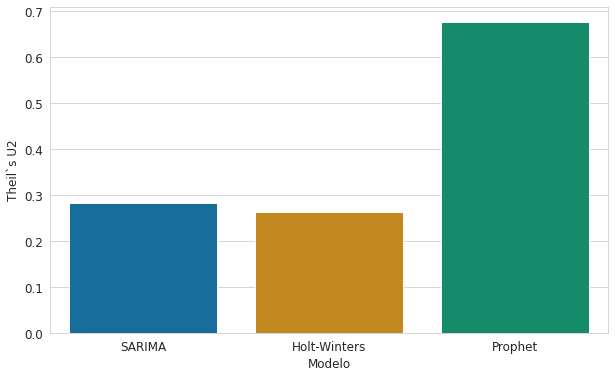

In [ ]:
plotPerformanceComparation(df_u2_china, "Theil`s U2")

<h3>Alemanha</h3>

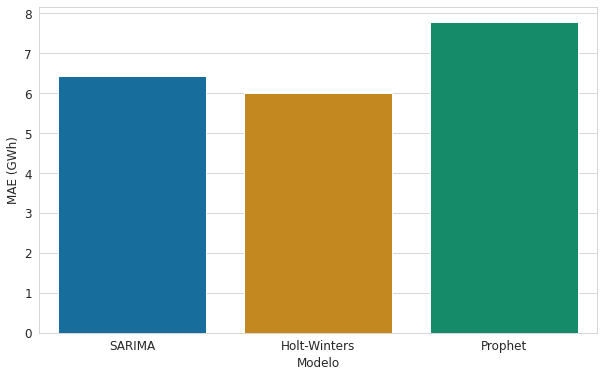

In [ ]:
plotPerformanceComparation(df_mae_germany, "MAE")

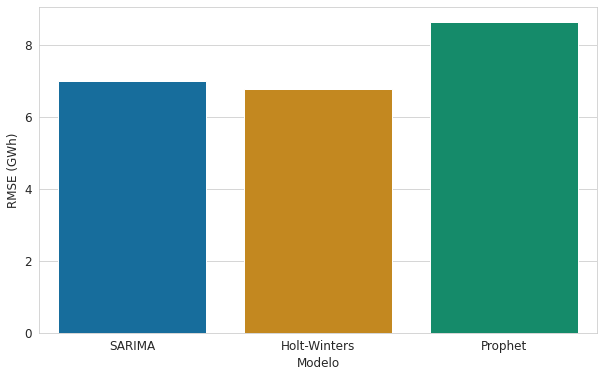

In [ ]:
plotPerformanceComparation(df_rmse_germany, "RMSE")

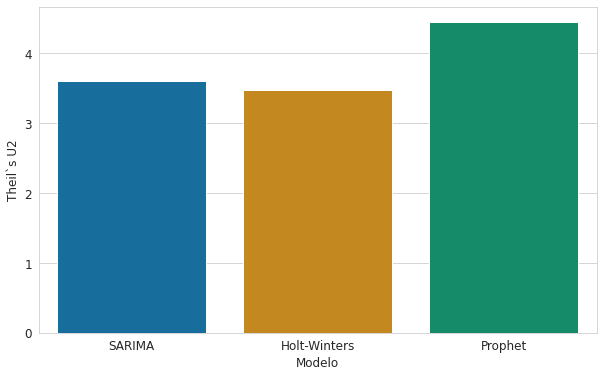

In [ ]:
plotPerformanceComparation(df_u2_germany, "Theil`s U2")

<h2>Conclusão.</h2>

Conduzimos uma análise exploratória das séries temporais da produção de eletricidade da China e Alemanha. Construímos modelos de predição com base em diferentes algoritmos e os avaliamos com múltiplas métricas, incluindo a U de Theil, em suas duas versões. Considerando os resultados obtidos, o modelo desenvolvido com base no método de Holt-Winters superou os demais modelos. 


Como podemos observar nos resultados obtidos, os valores da U2 variam entre conjuntos de dados e para diferentes modelos. Todos os modelos construídos com os dados da China conseguiram superar o método ingênuo. Por outro lado, para os dados da Alemanha, nenhum modelo conseguiu superar o mecanismo ingênuo. Ademais, pode-se observar que o valor de U2 varia entre os algoritmos analisados. Dessa forma, podemos identificar qual modelo apresentou o melhor resultado, mesmo quando superado pelo mecanismo ingênuo. Vale notar que a otimização dos parâmetros dos modelos pode contribuir para um aprimoramento no valor de U2.